## Filtering the Dataframe properly
1. order msut sum to 45
2. MatchID must be a valid number
3. Lane must be between 1 = 3
4. Hero ID must be between 1 - 138
5. MatchID must be unique and sum to exactly 10

In [1]:
import pandas as pd
df = pd.read_csv('large_amounts_of_data.csv')

# Keep only the first 10 consecutive rows of each match ID to prevent duplicated data
df_cleaned = df.groupby('MatchID').head(10)

# put the cleaned up data into a new file
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.to_csv('cleaned_data.csv', index=False)

df = pd.read_csv("cleaned_data.csv")
# Added in the bracer key late so the early models dont have it but it just means they were 0 so we can just make those values go to zero
df["bracer"].fillna(0, inplace=True)

#1. the ordrr must sum to 45
grouped = df.groupby("MatchID")["Order"].sum()
filtered_match_ids = grouped[grouped == 45].index
# Create a new DataFrame with only the rows corresponding to the filtered "MatchID"
df = df[df["MatchID"].isin(filtered_match_ids)]

# 2 and 3 remove the values of the dataframe where the match id is invalid or the lane is biggerr than 3 as this is ambigous and bad data 
cleaned_df = df[(df['MatchID'] > 100000) & (df["Lane"] < 4) & (df["Lane"] > 0)]

#4. hero id's between
cleaned_df = cleaned_df[cleaned_df["Hero ID"].between(1, 138)]

# 5. A valid match id must have exactly 10 matches
matchID_counts = cleaned_df['MatchID'].value_counts()
valid_matchID = matchID_counts[matchID_counts == 10].index
final_df = cleaned_df[cleaned_df["MatchID"].isin(valid_matchID)]
final_df


,Hero ID,Team,Order,MatchID,Lane,smoke_of_deceit,boots,flask,blood_grenade,clarity,...,ring_of_regen,sobi_mask,null_talisman,buckler,headdress,ring_of_basilius,wind_lace,boots_of_elves,dust,bracer
10,13,1,9,7425319964,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
11,46,1,6,7425319964,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
12,138,1,2,7425319964,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
13,83,1,5,7425319964,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
14,77,1,0,7425319964,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117741,136,0,4,6856407334,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117742,52,0,9,6856407334,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117743,85,0,1,6856407334,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117744,92,0,7,6856407334,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [2]:
final_df.head(10)

,Hero ID,Team,Order,MatchID,Lane,smoke_of_deceit,boots,flask,blood_grenade,clarity,...,ring_of_regen,sobi_mask,null_talisman,buckler,headdress,ring_of_basilius,wind_lace,boots_of_elves,dust,bracer
10,13,1,9,7425319964,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
11,46,1,6,7425319964,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
12,138,1,2,7425319964,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
13,83,1,5,7425319964,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
14,77,1,0,7425319964,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.0
15,89,0,7,7425319964,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
16,43,0,8,7425319964,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
17,74,0,1,7425319964,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
18,71,0,3,7425319964,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.0
19,58,0,4,7425319964,3,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0


In [19]:
from sklearn import tree
from sklearn.metrics import accuracy_score
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model = decision_tree_model.fit(final_df[["Hero ID", "Team", "Order", "smoke_of_deceit" ,
                                            "boots" ,
                                            "flask" ,
                                            "blood_grenade" ,
                                            "clarity" ,
                                            "enchanted_mango" ,
                                            "branches" ,
                                            "magic_stick" ,
                                            "faerie_fire" ,
                                            "circlet" ,
                                            "gauntlets" ,
                                            "ward_observer" ,
                                            "tango" ,
                                            "ward_sentry" ,                                            
                                            "slippers" ,
                                            "quelling_blade" ,
                                            "ring_of_protection" ,
                                            "magic_wand" ,
                                            "mantle" ,
                                            "crown" ,
                                            "chainmail" ,
                                            "blight_stone" ,
                                            "robe" ,
                                            "wraith_band" ,
                                            "gloves" ,
                                            "infused_raindrops" ,
                                            "blades_of_attack" ,
                                            "orb_of_venom" ,
                                            "tpscroll" ,
                                            "fluffy_hat" ,
                                            "ring_of_regen" ,
                                            "sobi_mask" ,
                                            "null_talisman" ,
                                            "buckler" ,
                                            "headdress" ,
                                            "ring_of_basilius" ,
                                            "wind_lace" ,
                                            "boots_of_elves" ,
                                            "dust" ,
                                            "bracer" ]], final_df["Lane"])

predicitons = decision_tree_model.predict(final_df[["Hero ID", "Team", "Order", "smoke_of_deceit" ,
                                            "boots" ,
                                            "flask" ,
                                            "blood_grenade" ,
                                            "clarity" ,
                                            "enchanted_mango" ,
                                            "branches" ,
                                            "magic_stick" ,
                                            "faerie_fire" ,
                                            "circlet" ,
                                            "gauntlets" ,
                                            "ward_observer" ,
                                            "tango" ,
                                            "ward_sentry" ,                                            
                                            "slippers" ,
                                            "quelling_blade" ,
                                            "ring_of_protection" ,
                                            "magic_wand" ,
                                            "mantle" ,
                                            "crown" ,
                                            "chainmail" ,
                                            "blight_stone" ,
                                            "robe" ,
                                            "wraith_band" ,
                                            "gloves" ,
                                            "infused_raindrops" ,
                                            "blades_of_attack" ,
                                            "orb_of_venom" ,
                                            "tpscroll" ,
                                            "fluffy_hat" ,
                                            "ring_of_regen" ,
                                            "sobi_mask" ,
                                            "null_talisman" ,
                                            "buckler" ,
                                            "headdress" ,
                                            "ring_of_basilius" ,
                                            "wind_lace" ,
                                            "boots_of_elves" ,
                                            "dust" ,
                                            "bracer" ]])
accuracy_score(predicitons, final_df["Lane"])
# four_random_rows = final_df.sample(11)
# four_random_rows
# print(decision_tree_model.predict(four_random_rows[["Hero ID", "Team", "Order"]]))
# four_random_rows

0.9597633136094674

In [ ]:
import graphviz

dot_data = tree.export_graphviz(decision_tree_model)

In [7]:
def getOrderOnTeam(row):
    match = final_df[final_df["MatchID" == row["MatchID"]] & final_df["Team"== row["Team"]]]
    # sort in descending order
    match = match.sort_values(by = "Order", ascending = False)
    # get the index
    return match["Hero ID" == row["Hero ID"]].index[0]

    
final_df["OrderOnTeam"] = final_df.apply(getOrderOnTeam, axis = 1)

final_df.head(10)
    

KeyError: False

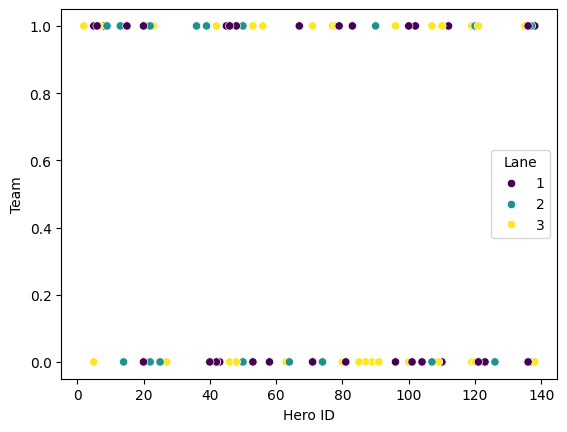

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Adjust column names accordingly

# Scatter plot
sns.scatterplot(x='Order', y='Team', hue='Lane', data=final_df.head(100), palette='viridis')

# Show the plot
plt.show()

# final_df["order_on_team"] = final_df.groupby("MatchID").groupyby("team")[]


## Sanity checks on the Data 

In [2]:
#confirmation check that we cleaned properly
result = final_df.groupby("MatchID")["Order"].sum()
result = result.reset_index()
filter = result[result["Order"] != 45]
filter

final_df["MatchID"].value_counts().sort_values(ascending=True)


MatchID
7425319964    10
7424409681    10
7425165105    10
7425127995    10
7425116440    10
              ..
6856228942    10
6856241408    10
6856242219    10
6854304277    10
6856407334    10
Name: count, Length: 10816, dtype: int64


If you want to use a neural network with a 10*44 matrix as input instead of a 1-D input vector, you can employ a specific type of neural network architecture known as a "2D Convolutional Neural Network" or "2D CNN." 2D CNNs are well-suited for processing grid-like data such as images or matrices. In your case, where you have a matrix of 10 rows and 44 columns as input for each match, a 2D CNN can be an appropriate choice. 
Please let me know if you have any questions.

## ConvolutionNeural Network for 2D matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a Sequential model
model = keras.Sequential()

# Add a 2D convolutional layer with 32 filters
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(10, 44, 1)))

# Add a max-pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(layers.Flatten())

# Add a dense (fully connected) layer with 64 units
model.add(layers.Dense(64, activation='relu'))

# Add the output layer with as many units as the number of lane classes
# Adjust the number of units according to your specific problem
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary

model.summary()

2023-11-14 23:27:04.987569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 23:27:07.291522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 23:27:07.291596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 23:27:07.294984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 23:27:08.190452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 23:27:08.192217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 42, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 21, 32)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2688)              0         
                                                                 
 dense (Dense)               (None, 64)                172096    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 173066 (676.04 KB)
Trainable params: 173066 (676.04 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
class ConvNetModel(nn.Module):
    def __init__(self, debug=False):
        super(ConvNetModel, self).__init__()
        self.debug = debug

        ### START YOUR CODE ###
        # The first convolutional layer has in_channels=1, out_channels=6, kernel_size=3, with default stride=1 and padding=0
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(10)
        # The first pooling layer is a maxpool with a square window of kernel_size=2 (default stride is same as kernel_size)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # The second convolutional layer
        # NOTE: Its in_channels should match the out_channels of conv1
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=24, kernel_size=3, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(24)
        # The second pooling layer is maxpool with a square window of kernel_size=2
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # The fully-connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=24, out_features=10) # Use nn.Linear, and you need to specify the correct in_features and out_features
        
        # Softmax layer
        self.output = nn.LogSoftmax(dim=1) # Use nn.LogSoftmax(), specify the dim correctly
        ### END YOUR CODE ###
        
    
    def forward(self, x):
        # Conv1 -> ReLU -> Batchnorm1-> Pool1
        reluObject = nn.ReLU()
        x = self.conv1(x) 
        x = reluObject(x)
        x = self.bn1(x)
        x = self.pool1(x)

        if self.debug:
            print('output shape of pool1:', x.shape)
        
        ### START YOUR CODE ###
        # Conv2 -> ReLU -> Batchnorm2 -> Pool2
        x = self.conv2(x) 
        x = reluObject(x)
        x = self.bn2(x)
        x = self.pool2(x)
        if self.debug:
            print('output shape of pool2:', x.shape)
        
        # Flatten the output from the last pooling layer
        x = self.flatten(x)
        
        # Call the fully-connected layer, followed by a F.relu()
        x = self.fc(x)
        x = F.relu(x)
        
        # Call softmax layer
        x = self.output(x)
        ### END YOUR CODE ###
        
        return x

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your DataFrame

# Prepare your input data (features)
X = df.iloc[:, 5:].values  # Select columns from 6th to the end (excluding "Lane")
X = X.reshape(-1, 10, 44, 1)  # Reshape to (number_of_samples, 10, 44, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Perform one-hot encoding on the labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the 2D CNN model (as defined in the previous answer)


# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')


ValueError: cannot reshape array of size 4707600 into shape (10,44,1)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load your data into a Pandas DataFrame
# Assuming your DataFrame is named df
# You might need to adjust the path or method based on your actual data loading process
# df = pd.read_csv('your_data.csv')

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes
num_matches = len(df['MatchID'].unique())

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes

# Calculate the number of matches based on unique MatchID values
num_matches = len(df['MatchID'].unique())

# Reshape X
X = X.reshape(num_matches, num_heroes, num_features, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_heroes, num_features, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


ValueError: cannot reshape array of size 4707600 into shape (11769,10,4,1)

In [14]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/home/codespace/.fastai/data/adult_sample/adult.csv'),Path('/home/codespace/.fastai/data/adult_sample/models'),Path('/home/codespace/.fastai/data/adult_sample/export.pkl')]

In [8]:
df = pd.read_csv(path/'adult.csv')
df.head()


NameError: name 'path' is not defined

In [16]:
import pandas as pd

data = {'Age': [30, 35, 25, 40, 32, 28, 45, 22, 38, 33],
        'Income': [50000, 60000, 45000,70000,55000,48000,75000,40000,65000,58000],
        'Loan Approval': ['Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No']}

df = pd.DataFrame(data)
df.sort_values(by='Age')
df.sort_values(by='Income')


,Age,Income,Loan Approval
7,22,40000,No
2,25,45000,No
5,28,48000,No
0,30,50000,Yes
4,32,55000,No
9,33,58000,No
1,35,60000,Yes
8,38,65000,Yes
3,40,70000,Yes
6,45,75000,Yes
